Attacks

In [2]:
#!pip install opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
import tarfile
import torch
import requests
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision
import torch.utils.data as torch_data
import torchvision.transforms as transforms
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import math
#from google.colab import files

In [ ]:
## download the data
response = requests.get(f'https://www.comp.nus.edu.sg/~reza/files/dataset_texas.tgz')
if response.status_code == 200:
    with open(f'dataset_texas.tgz', 'wb') as file:
        file.write(response.content)
    print("Download completed successfully.")
else:
    print(f"Failed to download file: {response.status_code}")


In [4]:
with tarfile.open(f'dataset_texas.tgz') as f:
    f.extractall(f'data/')

with open('data/texas/100/feats', 'r') as f:
    features = f.readlines()
with open('data/texas/100/labels', 'r') as f:
    labels = f.readlines()

In [14]:
## build the sampled trainig and test datasets
features_list = [list(map(int, ''.join(feature.split()).split(','))) for feature in features]
labels_list = [int(label.strip()) for label in labels]
size = int(0.8 * len(features))
sample_size = 100
## sample dataset for inference attacks
feat_tens = torch.tensor(features_list[size-sample_size:size+sample_size], dtype=torch.float, requires_grad = True)
l_tens = torch.tensor(labels_list[size-sample_size:size+sample_size], dtype=torch.long)
dataset = TensorDataset(feat_tens, l_tens)


## true train and test datasets
feat_tens_train = torch.tensor(features_list[size-sample_size:size], dtype=torch.float)
l_tens_train = torch.tensor(labels_list[size-sample_size:size], dtype=torch.long)
#feat_tens_test = torch.tensor(features_list[size:], dtype=torch.float)
#l_tens_test = torch.tensor(labels_list[size:], dtype=torch.long)
dataset_train = TensorDataset(feat_tens_train, l_tens_train)
#dataset_test = TensorDataset(feat_tens_test, l_tens_test)

In [6]:
print(os.getcwd())
current_dir = os.getcwd()
model_path = os.path.join(current_dir,'..','Models','model_S.pth')

print(model_path)

C:\Users\ale_m\Desktop\Alles\Università\Unibas\04 Privacy-preserving methods\PrivacyProject\Membership_inference
C:\Users\ale_m\Desktop\Alles\Università\Unibas\04 Privacy-preserving methods\PrivacyProject\Membership_inference\..\Models\model_S.pth


In [18]:
## model class
class NetSeq(nn.Module):
    def __init__(self):
        super(NetSeq, self).__init__()
        self.fc1 = nn.Linear(6169, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 101)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
## load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_state_dict = torch.load(model_path)
model = NetSeq()
model.load_state_dict(model_state_dict)
model.eval()

NetSeq(
  (fc1): Linear(in_features=6169, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=101, bias=True)
)

In [22]:
## evaluate the model and compute loss
criterion = nn.CrossEntropyLoss()
data_loader = DataLoader(dataset, batch_size = 1, shuffle = False)
results = []
with torch.no_grad():
    for feat, lab in data_loader:
        # Forward pass
        outputs = model(feat)    
        # Compute loss
        loss = criterion(outputs, lab) 
        # Store the feature values and loss
        results.append((feat.numpy(), lab.numpy(), loss.item()))

## sort per loss increasingly
sorted_results = sorted(results, key = lambda x: x[2])
predicted_members = sorted_results[:sample_size]
print(len(sorted_results))
print(len(predicted_members))
##print(sorted_results[999][2])
## max loss as an upper bound for threshold in a ROC curve
max_loss = sorted_results[len(sorted_results)-1][2]
max_loss2 = predicted_members[len(predicted_members)-1][2]
int_max_loss = math.ceil(max_loss)
print(int_max_loss, max_loss2)

200
100
8 0.2831069827079773


In [24]:
## the idea is that the value for which the loss is smaller are the one that are more likely to be member of the training set
trainloader = DataLoader(dataset_train, batch_size=1, shuffle=False)

train_features_set = {tuple(features.numpy().flatten()) for features, _ in trainloader}

count_actual_members = sum(1 for feats, lab, loss in predicted_members if tuple(feats.flatten()) in train_features_set)

        
print('absolute number of correct predictions:',count_actual_members)
print('accuracy of prediction:', count_actual_members/sample_size)


absolute number of correct predictions: 53
accuracy of prediction: 0.53


8
0.0
0 0
0.8
138 72
1.6
169 88
2.4
185 94
3.2
195 100
4.0
197 100
4.8
199 100
5.6
199 100
6.4
199 100
7.2
199 100
8.0
200 100


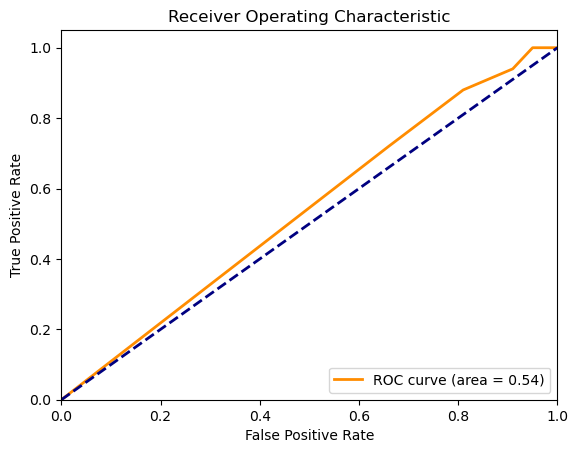

In [26]:
m = 10
TP_count = []
FP_count = []
TN_count = []
FN_count = []
print(int_max_loss)
for i in range(m+1):
    thresh = i/m*int_max_loss
    print(thresh)
    prediction = [item for item in sorted_results if item[2] < thresh]
    count_prediction = len(prediction)
    count_act_mem = sum(1 for feats, lab, loss in prediction if tuple(feats.flatten()) in train_features_set)
    print(count_prediction, count_act_mem)
    TP_count.append(count_act_mem)
    FP_count.append(count_prediction-count_act_mem)
    TN_count.append(sample_size - count_prediction + count_act_mem)
    FN_count.append(sample_size - count_act_mem)

    
TPR = [TP / (TP + FN) for TP, FN in zip(TP_count, FN_count)]  # True Positive Rate
FPR = [FP / (FP + TN) for FP, TN in zip(FP_count, TN_count)]  # False Positive Rate
    
roc_auc = np.trapz(TPR, FPR)

# Plot ROC curve
plt.figure()
plt.plot(FPR, TPR, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
    

In [ ]:
model = 'blabla' ## salvati come pth


x, y = 'sample of n elements'  ## check how to sample from tensor datasets
losses = 'array of losses for model(x), y'
sorted_elem = 'sort losses increasingly'

## assume that 50% of x are in the training set
## pick first n/2 x wrt to sorted loss
## check how many of these are actually in the training dataset

## in case of unknown percentage
max_loss = 'max loss'
threshold = 'between 0 and max_loss, intervall max_loss/100'

## ROc curve, for each threshold comupte how many x are chosen as members
## compute ratio TPR/FPR and plot the curve


In [34]:
def compute_gradient_norm_wrt_input(model, feature, label, criterion):
    #feature = feature.unsqueeze(0)
    #label = label.unsqueeze(0)
    feature.requires_grad = True
    feature, label = feature.to(device), label.to(device)
    model_gpu = model.to(device)
    output = model_gpu(feature)
    loss = criterion(output, label)
    
    model.train()
    loss.backward()
    
    grads = feature.grad
    grad_norm = torch.sqrt(torch.sum(grads ** 2)).item()
    
    return grad_norm

In [40]:

criterion = nn.CrossEntropyLoss()
results_gradnorm = []
with torch.no_grad():
    for feat, lab in data_loader:
        grad_norm = compute_gradient_norm_wrt_input(model, feat, lab, criterion)
        results_gradnorm.append((feat.cpu().numpy(), lab.cpu().numpy(), grad_norm))
        
sorted_results = sorted(results_gradnorm, key=lambda x: x[2])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn